In [0]:
%tensorflow_version 2.x
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import random
%matplotlib inline

In [41]:
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
print(tf.__version__)

2.1.0


In [42]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Load dataset
names = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/capstone2/gender_classification/names.csv')
names['Name'] = names['Name'].str.strip()
names['Name'] = names['Name'].str.lower()
names['FirstLetter'] = names['FirstLetter'].str.lower()

In [44]:
names.head(5)

,Name,Gender,LastLetter,LastTwoLetter,FirstLetter
0,ashutosh,1,h,sh,a
1,meghamala,2,a,la,m
2,sahib,1,b,ib,s
3,pragya,2,a,ya,p
4,kranti,2,i,ti,k


# Naive Bayes on the last letter

In [0]:
last_letter = names.LastLetter.values

In [0]:
labels = names.Gender.values

In [0]:
def naive_bayes_classifier(features, labels):
  # Split the data into a training and test set.
  X_train, X_test, y_train, y_test = train_test_split(features.reshape(-1, 1), 
                                                      labels.reshape(-1, 1).ravel(), 
                                                      test_size = 0.3,
                                                      stratify = labels)

  encoder = OneHotEncoder(handle_unknown='ignore')
  X_train = encoder.fit_transform(X_train)
  X_test = encoder.transform(X_test)

  nb_clf = MultinomialNB()

  # Fit the model on the trainng data.
  nb_clf.fit(X_train, y_train)

  # Print the accuracy from the training data.
  print('The mean accuracy on the given train data and labels = ' + 
        str(nb_clf.score(X_train, y_train)))

  # Print the accuracy from the testing data.
  print('The mean accuracy on the given test data and labels = ' + 
        str(nb_clf.score(X_test, y_test)))

  print('Precision: %.3f' 
        %precision_score(y_true=y_test, y_pred=nb_clf.predict(X_test)))
  print('Recall: %.3f' 
        %recall_score(y_true=y_test, y_pred=nb_clf.predict(X_test)))
  print('F1: %.3f' 
        %f1_score(y_true=y_test, y_pred=nb_clf.predict(X_test)))

In [48]:
naive_bayes_classifier(last_letter, labels)

The mean accuracy on the given train data and labels = 0.8220579874928937
The mean accuracy on the given test data and labels = 0.8184227965540093
Precision: 0.902
Recall: 0.737
F1: 0.811


# Naive Bayes on the last two letters

In [0]:
last_two_letters = names.LastTwoLetter.values

In [50]:
naive_bayes_classifier(last_two_letters, labels)

The mean accuracy on the given train data and labels = 0.8354178510517339
The mean accuracy on the given test data and labels = 0.827037773359841
Precision: 0.857
Recall: 0.809
F1: 0.832


# Naive Bayes on the first letter

In [0]:
first_letter = names.FirstLetter.values

In [52]:
naive_bayes_classifier(first_letter, labels)

The mean accuracy on the given train data and labels = 0.5574189880613986
The mean accuracy on the given test data and labels = 0.5394300861497681
Precision: 0.553
Recall: 0.681
F1: 0.610


# SVM on tfidf vectorized dataset

In [0]:
from sklearn.svm import SVC

def svm_classifier(df):

    labels = (df.Gender == 1).values.astype(np.int)
    features = df.Name

    # Split the data into a training and test set.
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        labels.reshape(-1, 1).ravel(), 
                                                        test_size = 0.3,
                                                        stratify = labels)

    vectorizer = TfidfVectorizer(min_df=0.0, analyzer='char', 
                                 ngram_range=(2, 3), 
                                 decode_error='ignore')
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    svm_clf = SVC(C=0.75, kernel='linear')

    # Fit the model on the trainng data.
    svm_clf.fit(X_train, y_train)

    # Print the accuracy from the training data.
    print('The mean accuracy on the given train data and labels = ' + 
          str(svm_clf.score(X_train, y_train)))

    # Print the accuracy from the testing data.
    print('The mean accuracy on the given test data and labels = ' + 
          str(svm_clf.score(X_test, y_test)))
    print('Precision: %.3f' 
          %precision_score(y_true=y_test, 
                           y_pred=svm_clf.predict(X_test)))
    print('Recall: %.3f' 
          %recall_score(y_true=y_test, 
                        y_pred=svm_clf.predict(X_test)))
    print('F1: %.3f' 
          %f1_score(y_true=y_test, 
                    y_pred=svm_clf.predict(X_test)))

In [54]:
svm_classifier(names)

The mean accuracy on the given train data and labels = 0.8749289368959636
The mean accuracy on the given test data and labels = 0.7925778661365143
Precision: 0.781
Recall: 0.846
F1: 0.812


# Train-test split for neural networks

In [0]:
def make_nn_train_test(df):   

    random.seed(1) 
    
    labels = (df.Gender == 1).values.astype(np.int)
    features = df.Name

    # Using train_test_split() to get train and test datasets from intitial dataset
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        labels.reshape(-1, 1).ravel(), 
                                                        test_size = 0.3,
                                                        stratify = labels)

    vectorizer = TfidfVectorizer(min_df=0.0, 
                                 analyzer='char', 
                                 ngram_range=(2, 3), 
                                 decode_error='ignore')
  
    X_train = vectorizer.fit_transform(X_train).toarray()
    X_test = vectorizer.transform(X_test).toarray()

    ds_train_valid = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_train = ds_train_valid.take(int(0.7 * np.shape(X_train)[0]))
    ds_valid = ds_train_valid.skip(int(0.7 * np.shape(X_train)[0]))
    ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    input_shape = np.shape(X_train)[1]
    ds_train_len = len(X_train)

    return ds_train, ds_valid, ds_test, input_shape, ds_train_len    

In [0]:
ds_train_orig, ds_valid_orig, ds_test, nn_input_shape, ds_train_len = make_nn_train_test(names)

In [141]:
ds_valid_orig

<SkipDataset shapes: ((2716,), ()), types: (tf.float64, tf.int64)>

In [142]:
train_size = 0
for example in ds_train_orig:
    train_size += 1
print(train_size)

valid_size = 0
for example in ds_valid_orig:
    valid_size += 1
print(valid_size)

test_size = 0
for example in ds_test:
    test_size += 1
print(test_size)

2462
1056
1509


In [0]:
def fitting_neural_network(model, batch, epochs):
    
    num_epochs = epochs
    batch_size = batch
    steps_train = np.ceil(train_size / batch_size)
    steps_valid = np.ceil(valid_size / batch_size)

    ds_train = ds_train_orig.shuffle(buffer_size=train_size)
    ds_train = ds_train.repeat()
    ds_train = ds_train.batch(batch_size=batch_size)
    ds_train = ds_train.prefetch(buffer_size=1000)

    ds_valid = ds_valid_orig.shuffle(buffer_size=valid_size)
    ds_valid = ds_valid.repeat()
    ds_valid = ds_valid.batch(batch_size=batch_size)
    ds_valid = ds_valid.prefetch(buffer_size=1000)

    history = model.fit(ds_train, 
                        epochs=num_epochs, 
                        steps_per_epoch=steps_train, 
                        validation_data = ds_valid, 
                        validation_steps = steps_valid)
    return history

# Multilayer perceptron

In [177]:
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(150, 
                          activation='relu', 
                          name='fully_connected1', 
                          input_shape=(nn_input_shape,)),
    tf.keras.layers.Dropout(rate = 0.9,
                            name='dropout1'),
    tf.keras.layers.Dense(150, 
                          activation='relu', 
                          name='fully_connected2'),
    tf.keras.layers.Dropout(rate = 0.9,
                            name='dropout2'),
    tf.keras.layers.Dense(150, 
                          activation='relu', 
                          name='fully_connected3'),
    tf.keras.layers.Dense(2, 
                          name='output', 
                          activation='sigmoid')])

mlp_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fully_connected1 (Dense)     (None, 150)               407550    
_________________________________________________________________
dropout1 (Dropout)           (None, 150)               0         
_________________________________________________________________
fully_connected2 (Dense)     (None, 150)               22650     
_________________________________________________________________
dropout2 (Dropout)           (None, 150)               0         
_________________________________________________________________
fully_connected3 (Dense)     (None, 150)               22650     
_________________________________________________________________
output (Dense)               (None, 2)                 302       
Total params: 453,152
Trainable params: 453,152
Non-trainable params: 0
_______________________________________________

In [0]:
mlp_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [179]:
mlp_hist = fitting_neural_network(mlp_model, batch = 4, epochs = 10)

Train for 616.0 steps, validate for 264.0 steps
Epoch 1/10
616/616 [==============================] - 3s 5ms/step - loss: 0.6969 - accuracy: 0.5199 - val_loss: 0.6883 - val_accuracy: 0.5445
Epoch 2/10
616/616 [==============================] - 2s 4ms/step - loss: 0.6915 - accuracy: 0.5357 - val_loss: 0.6860 - val_accuracy: 0.5549
Epoch 3/10
616/616 [==============================] - 2s 4ms/step - loss: 0.6936 - accuracy: 0.5195 - val_loss: 0.6848 - val_accuracy: 0.5502
Epoch 4/10
616/616 [==============================] - 2s 4ms/step - loss: 0.6879 - accuracy: 0.5333 - val_loss: 0.6782 - val_accuracy: 0.5739
Epoch 5/10
616/616 [==============================] - 2s 4ms/step - loss: 0.6842 - accuracy: 0.5674 - val_loss: 0.6720 - val_accuracy: 0.5786
Epoch 6/10
616/616 [==============================] - 2s 4ms/step - loss: 0.6834 - accuracy: 0.5686 - val_loss: 0.6631 - val_accuracy: 0.6098
Epoch 7/10
616/616 [==============================] - 2s 4ms/step - loss: 0.6698 - accuracy: 0.5958 

In [0]:
def plot_train_valid(model_history):
    hist = model_history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)

    return plt.show()

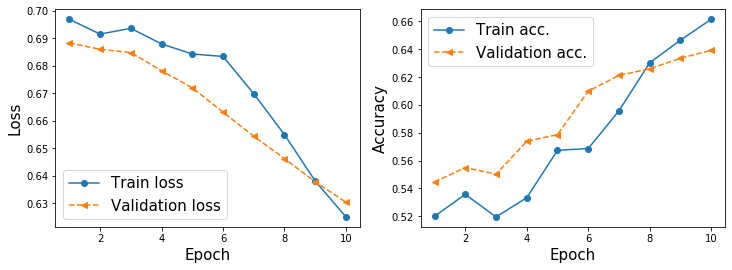

In [181]:
plot_train_valid(mlp_hist)

In [173]:
mlp_results = mlp_model.evaluate(ds_test.batch(test_size))
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*mlp_results))

1/1 [==============================] - 0s 40ms/step - loss: 0.5676 - accuracy: 0.7091
Test loss: 0.5676   Test Acc.: 0.7091


# Simple RNN network.

In [0]:
tf.random.set_seed(1)

embedding_dim = 100

rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(nn_input_shape, 
                              embedding_dim,
                              name = 'embedding'),
    tf.keras.layers.SimpleRNN(100, 
                              return_sequences=True,
                              name = 'simple_rnn1'),
    tf.keras.layers.SimpleRNN(100, 
                              return_sequences=False,
                              name = 'simple_rnn2'),
    tf.keras.layers.Dense(100, 
                          activation = 'relu',
                          name = 'dense1'),
    tf.keras.layers.Dense(2, 
                          activation = 'softmax',
                          name = 'output')])

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         261400    
_________________________________________________________________
simple_rnn1 (SimpleRNN)      (None, None, 100)         20100     
_________________________________________________________________
simple_rnn2 (SimpleRNN)      (None, 100)               20100     
_________________________________________________________________
dense1 (Dense)               (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 2)                 202       
Total params: 311,902
Trainable params: 311,902
Non-trainable params: 0
_________________________________________________________________


In [0]:
rnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [0]:
rnn_hist = fitting_neural_network(rnn_model, batch=8, epochs=5)

Train for 264.0 steps, validate for 114.0 steps
Epoch 1/5
264/264 [==============================] - 1128s 4s/step - loss: 0.7240 - accuracy: 0.4872 - val_loss: 0.6927 - val_accuracy: 0.5493
Epoch 2/5
264/264 [==============================] - 1137s 4s/step - loss: 0.7042 - accuracy: 0.5118 - val_loss: 0.6893 - val_accuracy: 0.5493
Epoch 3/5
264/264 [==============================] - 1167s 4s/step - loss: 0.6976 - accuracy: 0.5090 - val_loss: 0.7059 - val_accuracy: 0.4496
Epoch 4/5
264/264 [==============================] - 1169s 4s/step - loss: 0.6934 - accuracy: 0.5317 - val_loss: 0.6887 - val_accuracy: 0.5482
Epoch 5/5
264/264 [==============================] - 1156s 4s/step - loss: 0.6940 - accuracy: 0.5090 - val_loss: 0.6921 - val_accuracy: 0.5471


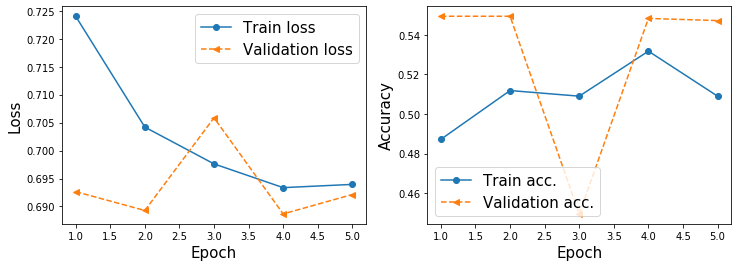

In [0]:
plot_train_valid(rnn_hist)

In [0]:
# evaluate on the test data
rnn_results = rnn_model.evaluate(ds_test.batch(10))
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*rnn_results))

202/202 [==============================] - 72s 358ms/step - loss: 0.6926 - accuracy: 0.5296
Test loss: 0.6926   Test Acc.: 0.5296


# Bidirectional with LSTM layer.

In [187]:
embedding_dim = 30
vocab_size = nn_input_shape + 2

bi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              name='embed-layer'),
    
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(100, 
                             name='lstm-layer'),
                             name='bidir-lstm'), 

    tf.keras.layers.Dense(100, 
                          activation='relu'),
    
    tf.keras.layers.Dense(2, 
                          activation = 'softmax',
                          name = 'output')
])

bi_lstm_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 30)          81540     
_________________________________________________________________
bidir-lstm (Bidirectional)   (None, 200)               104800    
_________________________________________________________________
dense_18 (Dense)             (None, 100)               20100     
_________________________________________________________________
output (Dense)               (None, 2)                 202       
Total params: 206,642
Trainable params: 206,642
Non-trainable params: 0
_________________________________________________________________


In [0]:
bi_lstm_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [190]:
bi_lstm_hist = fitting_neural_network(bi_lstm_model, batch=4, epochs=5)

Train for 616.0 steps, validate for 264.0 steps
Epoch 1/5
616/616 [==============================] - 123s 200ms/step - loss: 0.6936 - accuracy: 0.5183 - val_loss: 0.6909 - val_accuracy: 0.5445
Epoch 2/5
616/616 [==============================] - 123s 199ms/step - loss: 0.6932 - accuracy: 0.5126 - val_loss: 0.6911 - val_accuracy: 0.5445
Epoch 3/5
616/616 [==============================] - 123s 199ms/step - loss: 0.6943 - accuracy: 0.5203 - val_loss: 0.6892 - val_accuracy: 0.5445
Epoch 4/5
616/616 [==============================] - 123s 200ms/step - loss: 0.6927 - accuracy: 0.5219 - val_loss: 0.6916 - val_accuracy: 0.5445
Epoch 5/5
616/616 [==============================] - 123s 200ms/step - loss: 0.6927 - accuracy: 0.5207 - val_loss: 0.6909 - val_accuracy: 0.5445


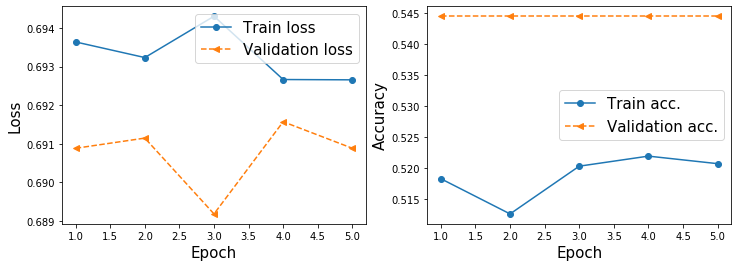

In [191]:
plot_train_valid(bi_lstm_hist)

In [192]:
# evaluate bi_lstm_model on the test data
bi_lstm_results = bi_lstm_model.evaluate(ds_test.batch(10))
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*bi_lstm_results))

151/151 [==============================] - 11s 74ms/step - loss: 0.6918 - accuracy: 0.5295
Test loss: 0.6918   Test Acc.: 0.5295


# Bidirectional LSTM with multiple dropout payers.

In [194]:
embedding_dim = 50
vocab_size = nn_input_shape + 2

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim),
    tf.keras.layers.Dense(50,
                          input_shape=(nn_input_shape,)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(50, 
                             return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, 
                          activation='softmax')
])

print(model.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 50)          135900    
_________________________________________________________________
dense_19 (Dense)             (None, None, 50)          2550      
_________________________________________________________________
dropout_23 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, None, 100)         40400     
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100)             

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
model_hist = fitting_neural_network(model, batch=4, epochs=8)

Train for 616.0 steps, validate for 264.0 steps
Epoch 1/8
616/616 [==============================] - 201s 327ms/step - loss: 0.6937 - accuracy: 0.5219 - val_loss: 0.6914 - val_accuracy: 0.5445
Epoch 2/8
616/616 [==============================] - 198s 322ms/step - loss: 0.6940 - accuracy: 0.5065 - val_loss: 0.6892 - val_accuracy: 0.5445
Epoch 3/8
616/616 [==============================] - 198s 322ms/step - loss: 0.6932 - accuracy: 0.5199 - val_loss: 0.6892 - val_accuracy: 0.5445
Epoch 4/8
524/616 [========================>.....] - ETA: 25s - loss: 0.6941 - accuracy: 0.5115

In [0]:
plot_train_valid(model_hist)